### 图像增广

##### 什么是图像增广？
回答：图像增广是对输入图像的大小，方向，颜色等做变换的一种图像预处理方式．

##### 为什么要做图像增广？
回答：图像增广一方面是为了扩大数据集规模，另一方面是为了提高模型的泛化能力．比如，如果在做aug时进行部分裁切>插值放大，能降低模型对input某一特定位置的这个属性的依赖；又比如，特定任务是目标检测，做aug预处理时改变input训练集的相位, 亮度等，能降低模型对特定颜色的依赖．


##### 图像增广的手段有哪些？
回答：翻转和裁剪，变化颜色（亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue））以及它们的相互叠加．

In [1]:
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append('../d2lzh/')
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
d2l.set_figsize()
img = Image.open('../Datasets/Butterfly.tif')
# d2l.plt.imshow(img)

In [4]:
# 绘图函数．给定subplots的行,列，约定了每张图像的大小．

def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    d2l.plt.show()
    return axes

In [5]:
#对单张图片做　num_rows * num_cols　次增广

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)


### 手段１．翻转和裁剪

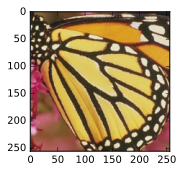

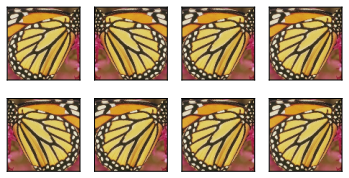

In [6]:
# 水平翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

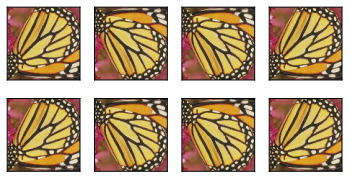

In [7]:
# 垂直翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

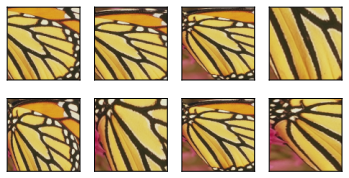

In [8]:
# 裁切

shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
# scale 参数，抽取原图像的10%-100%区域
# ratio表示该区域的宽高之比为0.5到2之间。
# size=200表示将最终图像放大到200x200

apply(img, shape_aug)


### 手段２．变化颜色

主要有：亮度（brightness）＼对比度(contrast)＼饱和度(saturation)＼色调(hue)

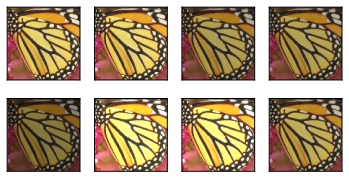

In [9]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

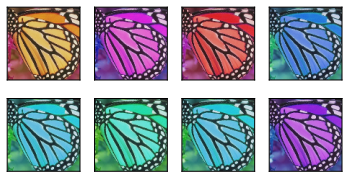

In [10]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

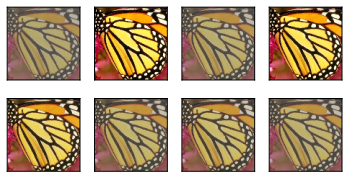

In [11]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

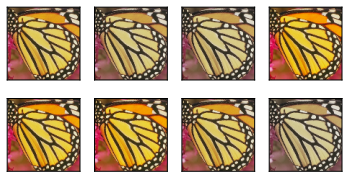

In [12]:
apply(img, torchvision.transforms.ColorJitter(saturation=0.5))

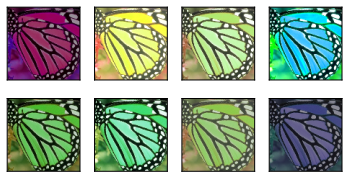

In [13]:
# 组合
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

### 手段３．叠加多种图像增广方法

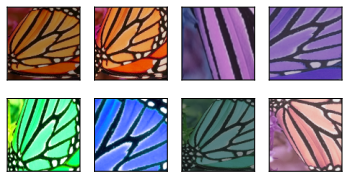

In [14]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(), color_aug, shape_aug
])

apply(img, augs)

### 使用图像增广来训练模型

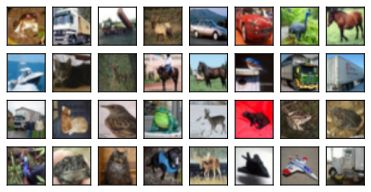

In [6]:
# 1. 准备数据

all_imgs = torchvision.datasets.CIFAR10(train=True, root='../Datasets/CIFAR10', download=False)

# all_imgs 中的每一个元素都是（image, label）
show_images([all_imgs[i][0] for i in range(32)], 4, 8, scale=0.8);

In [9]:
flip_aug = torchvision.transforms.Compose({
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
    })

# 保证输入数据的数据结构为：(通道大小，通道数，高，宽)，值域[０，１],32Float
no_aug = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

In [10]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root='../Datasets/CIFAR10'):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=False)
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [20]:
### ２．训练模型

In [17]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on:", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = d2l.evaluate_accuracy(test_iter, net)
        print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec." 
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time()-start))

In [18]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, d2l.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(is_train=True, train_augs, batch_size)
    test_iter = load_cifar10(is_train=False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)    

In [19]:
train_with_data_aug(flip_aug, no_aug)

training on: cuda
epoch 1, loss 1.4060, train acc 0.495, test acc 0.432, time 18.4 sec.
epoch 2, loss 0.5034, train acc 0.644, test acc 0.560, time 18.5 sec.
epoch 3, loss 0.2844, train acc 0.699, test acc 0.662, time 18.6 sec.
epoch 4, loss 0.1890, train acc 0.738, test acc 0.680, time 18.6 sec.
epoch 5, loss 0.1339, train acc 0.766, test acc 0.587, time 18.7 sec.
epoch 6, loss 0.1013, train acc 0.789, test acc 0.661, time 18.6 sec.
epoch 7, loss 0.0800, train acc 0.807, test acc 0.698, time 18.9 sec.
epoch 8, loss 0.0645, train acc 0.820, test acc 0.692, time 18.9 sec.
epoch 9, loss 0.0522, train acc 0.837, test acc 0.762, time 18.9 sec.
epoch 10, loss 0.0431, train acc 0.851, test acc 0.757, time 18.7 sec.
